
# Schechter Luminosity Function

This example demonstrates how to sample galaxies from a general Schechter
luminosity function as implemented in SkyPy.


## Joint Redshift-Magnitude Distribution

The number density of galaxies $N$ with luminosities $L$ in a
cosmic volume $V$ is widely observed to follow the Schechter luminosity
function $\phi$:

\begin{align}\phi(L) = \frac{{\rm d}N}{{\rm d}L{\rm d}V} =
   \phi_*\left(\frac{L}{L_*}\right)^\alpha{\rm exp}\left[-\frac{L}{L_*}\right].\end{align}

In SkyPy we reparameterise this distribution in terms of the absolute
magnitude $M$ of each galaxy:

\begin{align}\phi(M) = \frac{{\rm d}N}{{\rm d}M{\rm d}V} =
   \frac{2}{5}{\rm log}(10)\phi_*10^{\frac{2}{5}(M_*-M)(\alpha+1)}
   {\rm exp}\left[-10^{\frac{2}{5}(M_*-M)}\right].\end{align}

In general, $\phi_*$, $M_*$ and $\alpha$ can be redshift
dependent, resulting in a joint redshift-magnitude distribution
$\phi(M, z)$. In SkyPy, sampling from this joint distribution is
implemented in :func:`skypy.galaxies.schechter_lf` where both `phi_star` and
`m_star` can be either constants or functions of redshift. In this example,
we follow a common parameterisation where `phi_star` and `m_star` are
exponential and linear functions of redshift respectively. Samples are
generated for a given `sky_area` and over a given redshift range `z_range` up
to a limiting apparent magnitude `mag_lim` with shot noise. The values of the
parameters are taken from the B-band luminosity model for star-forming
galaxies in López-Sanjuan et al. 2017 [1]_.



In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.modeling.models import Linear1D, Exponential1D
from astropy.table import Table
from astropy.units import Quantity
from matplotlib import pyplot as plt
import numpy as np
from skypy.galaxies import schechter_lf

z_range = np.linspace(0.2, 1.0, 100)
m_star = Linear1D(-1.03, -20.485)
phi_star = Exponential1D(0.00312608, -43.4294)
alpha, mag_lim = -1.29, 30
sky_area = Quantity(2.381, "deg2")
cosmology = FlatLambdaCDM(H0=70, Om0=0.3)
redshift, magnitude = schechter_lf(z_range, m_star, phi_star, alpha,
                                   mag_lim, sky_area, cosmology, noise=True)

## ALHAMBRA B-Band Luminosity Function

Here we compare our sampled galaxy B-band magnitudes in four different
redshift slices to the observed B-band magnitude distribution of
star-forming galaxies in the ALHAMBRA survey and the median-redshift
model from López-Sanjuan et al. 2017. The data file can be downloaded
:download:`here <../../../examples/galaxies/lopez_sanjuan+17_B1.ecsv>`.



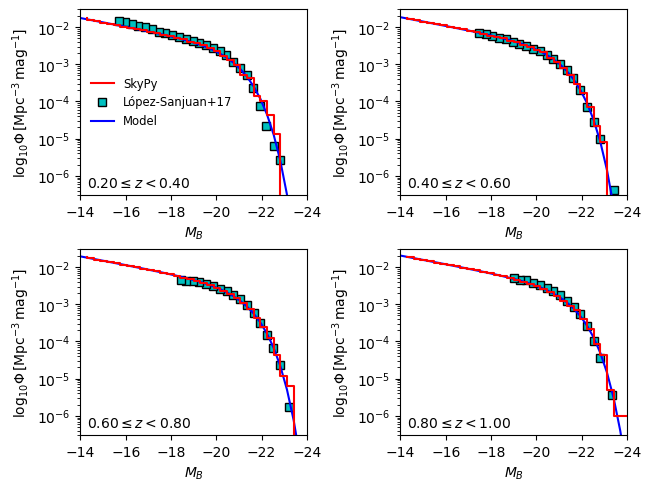

In [3]:
data = Table.read("lopez_sanjuan+17_B1.ecsv", format='ascii.ecsv')
fig, ((a1, a2), (a3, a4)) = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
bins = np.linspace(-24, -14, 35)
z_slices = ((0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0))

for ax, (z_min, z_max) in zip([a1, a2, a3, a4], z_slices):

    # Redshift grid
    z = np.linspace(z_min, z_max, 100)

    # SkyPy simulated galaxies
    z_mask = np.logical_and(redshift >= z_min, redshift < z_max)
    dV_dz = (cosmology.differential_comoving_volume(z) * sky_area).to_value('Mpc3')
    dV = np.trapz(dV_dz, z)
    dM = (np.max(bins)-np.min(bins)) / (np.size(bins)-1)
    phi_skypy = np.histogram(magnitude[z_mask], bins=bins)[0] / dV / dM

    # ALHAMBRA Survey star-forming galaxies (López-Sanjuan et al. 2017)
    M_data = data[f'MB_{z_min:.1f}_{z_max:.1f}']
    phi_data = 10 ** data[f'phi_{z_min:.1f}_{z_max:.1f}']

    # Median-redshift Schechter function
    L = 10 ** (0.4 * (m_star(z) - bins[:, np.newaxis]))
    phi_model_z = 0.4 * np.log(10) * phi_star(z) * L ** (alpha+1) * np.exp(-L)
    phi_model = np.median(phi_model_z, axis=1)

    # Plotting
    ax.step(bins[:-1], phi_skypy, where='post', label='SkyPy', color='r', zorder=3)
    ax.plot(M_data, phi_data, 's', mfc='c', mec='k', label='López-Sanjuan+17')
    ax.plot(bins, phi_model, label='Model', color='b')
    ax.text(-14.3, 5e-7, r'${:.2f} \leq z < {:.2f}$'.format(z_min, z_max))
    ax.set_xlabel(r'$M_B$')
    ax.set_ylabel(r'$\log_{10} \Phi \, [\mathrm{Mpc}^{-3} \, \mathrm{mag}^{-1}]$')
    ax.set_yscale('log')
    ax.set_xlim([-14, -24])
    ax.set_ylim([3e-7, 3e-2])

a1.legend(loc=6, fontsize='small', frameon=False)
plt.show()

## References


.. [1] López-Sanjuan, C. et al., `2017A&A…599A..62L`_


